# **Project Overview**


The aim behind the project is to make and demonstrate a **speech-based command understanding system** for surgical environments.  
The proposed pipeline integrates **speech recognition (Whisper)** with **natural language understanding (BERT)**  to predict the spoken surgical commands to the following categories:*Request Instrument*, *Adjust Device*, and *Request Information*.  

At this stage, experiments are conducted on a **custom-recorded dataset of 60 audio commands**, that I recorded to simulate the tone and delivery variations more realistically.

In the next phase, the system will be further evaluated on a **larger benchmark dataset (EndoVis MICCAI)** to assess its scalability and generalization capabilities.  


# ***First step: Setup***
Let’s start by connecting our Google Drive so we can access the first small
dataset and save our results:





In [1]:
#Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# To check that the project folder exists:
!ls "/content/drive/MyDrive/NLP_project"

 Audio					        fold_2
 audio_transcriptions_all.csv		        fold_2_merged
 audio_transcriptions.csv		        fold_3
 audio_transcriptions_noise.csv		        fold_3_merged
'audio_transcriptions_Reverb&Bass&Treble.csv'   fold_4
 Augmented-Audio-Noise			        fold_4_merged
'Augmented-Audio-Reverb&Bass&Treble'	        fold_5
 fold_1					        fold_5_merged
 fold_1_merged


In [3]:
!ls "/content/drive/MyDrive/NLP_project/Audio"


class1-Request-Instrument  class2-Adjust-Device  class3-Request-Info


In [4]:
!ls "/content/drive/MyDrive/NLP_project/Audio/class1-Request-Instrument"

1_Bring_me_clamp_fast_quiet.m4a     1_Need_retractor_fast_quiet.m4a
1_Bring_me_clamp_loud.m4a	    1_Need_retractor_loud.m4a
1_Give_me_forceps_fast_quiet.m4a    1_Need_suture_fast_quiet.m4a
1_Give_me_forceps_loud.m4a	    1_Need_suture_loud.m4a
1_Give_me_stapler_fast_quiet.m4a    1_Pass_needle_holder_fast_quiet.m4a
1_Give_me_stapler_loud.m4a	    1_Pass_needle_holder_loud.m4a
1_Hand_me_scalpel_fast_quiet.m4a    1_Pass_suction_tube_fast_quiet.m4a
1_Hand_me_scalpel_loud.m4a	    1_Pass_suction_tube_loud.m4a
1_Hand_over_syringe_fast_quiet.m4a  1_Prepare_scissors_fast_quiet.m4a
1_Hand_over_syringe_loud.m4a	    1_Prepare_scissors_loud.m4a


In [5]:
!ls "/content/drive/MyDrive/NLP_project/Audio/class2-Adjust-Device"

2_Adjust_microscope_focus_fast_quiet.m4a
2_Adjust_microscope_focus_loud.m4a
2_Increase_camera_brightness_fast_quiet.m4a
2_Increase_camera_brightness_loud.m4a
2_Increase_suction_power_fast_quiet.m4a
2_Increase_suction_power_loud.m4a
2_Lower_lighting_fast_quiet.m4a
2_Lower_lighting_loud.m4a
2_Move_arm_left_fast_quiet.m4a
2_Move_arm_left_loud.m4a
2_Reduce_table_height_fast_quiet.m4a
2_Reduce_table_height_loud.m4a
2_Set_ventilator_standby_fast_quiet.m4a
2_Set_ventilator_standby_loud.m4a
2_Stabilize_robotic_arm_fast_quiet.m4a
2_Stabilize_robotic_arm_loud.m4a
2_Turn_off_cauterizer_fast_quiet.m4a
2_Turn_off_cauterizer_loud.m4a
2_Zoom_in_endoscope_fast_quiet.m4a
2_Zoom_in_endoscope_loud.m4a


In [6]:
!ls "/content/drive/MyDrive/NLP_project/Audio/class3-Request-Info"

3_Camera_active_fast_quiet.m4a
3_Camera_active_loud.m4a
3_Display_anesthesia_level_fast_quiet.m4a
3_Display_anesthesia_level_loud.m4a
3_Oxygen_level_stable_fast_quiet.m4a
3_Oxygen_level_stable_loud.m4a
3_Patient_pulse_rate_fast_quiet.m4a
3_Patient_pulse_rate_loud.m4a
3_Pressure_normal_fast_quiet.m4a
3_Pressure_normal_loud.m4a
3_Recording_video_feed_fast_quiet.m4a
3_Recording_video_feed_loud.m4a
3_Show_blood_pressure_fast_quiet.m4a
3_Show_blood_pressure_loud.m4a
3_Suction_working_fast_quiet.m4a
3_Suction_working_loud.m4a
3_Temperature_reading_fast_quiet.m4a
3_Temperature_reading_loud.m4a
3_What_is_heart_rate_fast_quiet.m4a
3_What_is_heart_rate_loud.m4a


In [7]:
# Install dependencies
!pip install -q openai-whisper
!sudo apt update && sudo apt install -y ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 46.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,008 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.n

# ***Second step: Speech-to-Text Transcription (Whisper)***

let’s now load the **Whisper model** to automatically transcribe our recorded audio commands.  
Each audio file will be converted into text, and the transcriptions will later be used to train the BERT classifier.

In [8]:
# Prepare directories and CSV paths for Whisper transcription
import os
import csv
import whisper

# Defining base directory (where audio recordings are stored)
base_dir = "/content/drive/MyDrive/NLP_project/Audio"

# Define where to save the output transcriptions
output_csv = "/content/drive/MyDrive/NLP_project/audio_transcriptions.csv"


In [9]:
# Now let’s run the Whisper Model to automatically transcribe all the audio recordings
#This will create the dataset that contain each filename and its transcription and the corresponding label to be trained upon.

import whisper, os

model = whisper.load_model("small")

rows = [("filename", "transcription", "label")]

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    label = folder.split("-")[-1].strip().replace(" ", "_").lower()

    for file in os.listdir(folder_path):
        if not file.lower().endswith((".wav", ".m4a")):
            continue
        audio_path = os.path.join(folder_path, file)
        result = model.transcribe(audio_path)
        text = result["text"].strip()
        rows.append((file, text, label))

100%|████████████████████████████████████████| 461M/461M [00:02<00:00, 237MiB/s]


In [10]:
# Now let’s run the Whisper Model to automatically transcribe all the audio recordings
# This will create the dataset that contains each filename and its transcription and the corresponding label.

import whisper, os

# Main model
model = whisper.load_model("small")

# Baseline model
baseline_model = whisper.load_model("tiny")

# Updated rows to store BOTH transcriptions
rows = [("filename", "transcription_main", "transcription_baseline", "label")]

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    label = folder.split("-")[-1].strip().replace(" ", "_").lower()

    for file in os.listdir(folder_path):
        if not file.lower().endswith((".wav", ".m4a")):
            continue

        audio_path = os.path.join(folder_path, file)

        # Main model transcription
        result_main = model.transcribe(audio_path)
        text_main = result_main["text"].strip()

        # Baseline model transcription
        result_base = baseline_model.transcribe(audio_path)
        text_base = result_base["text"].strip()

        # Save both into the same row
        rows.append((file, text_main, text_base, label))


100%|██████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 271MiB/s]


In [11]:
#downloading the csv file so we can use it later for text classification
import csv

output_csv = "/content/drive/MyDrive/NLP_project/audio_transcriptions.csv"

with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("CSV saved successfully at:", output_csv)


CSV saved successfully at: /content/drive/MyDrive/NLP_project/audio_transcriptions.csv


In [12]:
!pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.2 MB/s eta 0:00:00


In [13]:
import pandas as pd
from jiwer import wer

# Load the CSV with both transcripts
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]

# Ground truth dictionary (same as before)
ground_truth = {
    # Class 1: Request Instrument
    "1_Bring_me_clamp_loud.m4a": "bring me clump.",
    "1_Give_me_forceps_loud.m4a": "give me forceps.",
    "1_Give_me_stapler_loud.m4a": "give me stapler.",
    "1_Hand_me_scalpel_loud.m4a": "hand me scalpel.",
    "1_Hand_over_syringe_loud.m4a": "hand over syringe.",
    "1_Need_retractor_loud.m4a": "need retractor.",
    "1_Need_suture_loud.m4a": "need suture.",
    "1_Pass_needle_holder_loud.m4a": "pass needle holder.",
    "1_Pass_suction_tube_loud.m4a": "pass suction tube.",
    "1_Prepare_scissors_loud.m4a": "prepare scissors.",

    # Class 2: Adjust Device
    "2_Adjust_microscope_focus_loud.m4a": "adjust microscope focus.",
    "2_Increase_camera_brightness_loud.m4a": "increase camera brightness",
    "2_Increase_suction_power_loud.m4a": "increase suction power",
    "2_Lower_lighting_loud.m4a": "lower lighting",
    "2_Move_arm_left_loud.m4a": "move arm left.",
    "2_Reduce_table_height_loud.m4a": "reduce table height.",
    "2_Set_ventilator_standby_loud.m4a": "set ventilator standby.",
    "2_Stabilize_robotic_arm_loud.m4a": "stabilize robotic arm",
    "2_Turn_off_cauterizer_loud.m4a": "turn off cauterizer.",
    "2_Zoom_in_endoscope_loud.m4a": "zoom in endoscope",

    # Class 3: Request Information
    "3_Camera_active_loud.m4a": "camera active",
    "3_Display_anesthesia_level_loud.m4a": "display anesthesia level.",
    "3_Oxygen_level_stable_loud.m4a": "oxygen level stable.",
    "3_Patient_pulse_rate_loud.m4a": "patient pulse rate.",
    "3_Pressure_normal_loud.m4a": "pressure normal.",
    "3_Recording_video_feed_loud.m4a": "recording video feed.",
    "3_Show_blood_pressure_loud.m4a": "show blood pressure",
    "3_Suction_working_loud.m4a": "suction working",
    "3_Temperature_reading_loud.m4a": "temperature reading.",
    "3_What_is_heart_rate_loud.m4a": "what is heart rate?",
}

results = []

for idx, row in df.iterrows():
    fname = row["filename"]
    true_text = ground_truth.get(fname, None)

    if true_text:
        # MAIN model WER
        pred_main = str(row["transcription_main"]).lower().strip()
        wer_main = wer(true_text, pred_main)
        exact_main = (wer_main == 0)

        # BASELINE model WER
        pred_base = str(row["transcription_baseline"]).lower().strip()
        wer_base = wer(true_text, pred_base)
        exact_base = (wer_base == 0)

        results.append(
            (fname, true_text, pred_main, pred_base,
             wer_main, wer_base, exact_main, exact_base)
        )

eval_df = pd.DataFrame(results, columns=[
    "filename", "ground_truth", "main_output", "baseline_output",
    "WER_main", "WER_baseline", "Exact_match_main", "Exact_match_baseline"
])

# Summary stats
avg_wer_main = eval_df["WER_main"].mean()
avg_wer_base = eval_df["WER_baseline"].mean()

exact_acc_main = eval_df["Exact_match_main"].mean() * 100
exact_acc_base = eval_df["Exact_match_baseline"].mean() * 100

print("Whisper Evaluation Results on Normal (loud) Recordings")
print(f"Average WER (Main - whisper small): {avg_wer_main:.2f}")
print(f"Average WER (Baseline - whisper tiny): {avg_wer_base:.2f}")
print(f"Exact Sentence Accuracy (Main): {exact_acc_main:.1f}%")
print(f"Exact Sentence Accuracy (Baseline): {exact_acc_base:.1f}%")

eval_df.head(30)

Whisper Evaluation Results on Normal (loud) Recordings
Average WER (Main - whisper small): 0.28
Average WER (Baseline - whisper tiny): 0.92
Exact Sentence Accuracy (Main): 63.3%
Exact Sentence Accuracy (Baseline): 10.0%


,filename,ground_truth,main_output,baseline_output,WER_main,WER_baseline,Exact_match_main,Exact_match_baseline
0,1_Bring_me_clamp_loud.m4a,bring me clump.,bring me clump.,pangm in clamp,0.000000,1.000000,True,False
1,1_Give_me_forceps_loud.m4a,give me forceps.,give me four subs.,give me four steps.,0.666667,0.666667,False,False
2,1_Give_me_stapler_loud.m4a,give me stapler.,give me stapler.,"give me a step, learn.",0.000000,1.000000,True,False
3,1_Hand_me_scalpel_loud.m4a,hand me scalpel.,hand miscalculable,handmeas nepal,0.666667,1.000000,False,False
4,1_Hand_over_syringe_loud.m4a,hand over syringe.,hand over syringe.,hand over the syringe,0.000000,0.666667,True,False
5,1_Need_retractor_loud.m4a,need retractor.,need retractor.,need with tractor,0.000000,1.000000,True,False
6,1_Need_suture_loud.m4a,need suture.,need sucher,ничего.,0.500000,1.000000,False,False
7,1_Pass_needle_holder_loud.m4a,pass needle holder.,pass needle holder.,past needle holder,0.000000,0.666667,True,False
8,1_Pass_suction_tube_loud.m4a,pass suction tube.,pass section tube.,pass which ones make up whether or not they're...,0.333333,5.000000,False,False
9,1_Prepare_scissors_loud.m4a,prepare scissors.,prepare scissors.,prepare scissors.,0.000000,0.000000,True,True


In [14]:
# Evaluate Whisper transcription accuracy on fast & quiet recordings

import pandas as pd
from jiwer import wer

# Load CSV with both transcriptions
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]

# Fast & Quiet ground truth dictionary (yours exactly)
ground_truth = {
    # Class 1: Request Instrument
    "1_Bring_me_clamp_fast_quiet.m4a": "bring me clump.",
    "1_Give_me_forceps_fast_quiet.m4a": "give me forceps.",
    "1_Give_me_stapler_fast_quiet.m4a": "give me stapler.",
    "1_Hand_me_scalpel_fast_quiet.m4a": "hand me scalpel.",
    "1_Hand_over_syringe_fast_quiet.m4a": "hand over syringe!",
    "1_Need_retractor_fast_quiet.m4a": "need retractor.",
    "1_Need_suture_fast_quiet.m4a": "need suture.",
    "1_Pass_needle_holder_fast_quiet.m4a": "pass needle holder.",
    "1_Pass_suction_tube_fast_quiet.m4a": "pass suction tube.",
    "1_Prepare_scissors_fast_quiet.m4a": "prepare scissors.",

    # Class 2: Adjust Device
    "2_Adjust_microscope_focus_fast_quiet.m4a": "adjust microscope focus.",
    "2_Increase_camera_brightness_fast_quiet.m4a": "increase camera brightness",
    "2_Increase_suction_power_fast_quiet.m4a": "increase suction power",
    "2_Lower_lighting_fast_quiet.m4a": "lower lighting",
    "2_Move_arm_left_fast_quiet.m4a": "move arm left.",
    "2_Reduce_table_height_fast_quiet.m4a": "reduce table height.",
    "2_Set_ventilator_standby_fast_quiet.m4a": "set ventilator standby.",
    "2_Stabilize_robotic_fast_quiet.m4a": "stabilize robotic arm",
    "2_Turn_off_cauterizer_fast_quiet.m4a": "turn off cauterizer.",
    "2_Zoom_in_endoscope_fast_quiet.m4a": "zoom in endoscope",

    # Class 3: Request Information
    "3_Camera_active_fast_quiet.m4a": "camera active",
    "3_Display_anesthesia_level_fast_quiet.m4a": "display anesthesia level.",
    "3_Oxygen_level_stable_fast_quiet.m4a": "oxygen level stable.",
    "3_Patient_pulse_rate_fast_quiet.m4a": "patient pulse rate.",
    "3_Pressure_normal_fast_quiet.m4a": "pressure normal.",
    "3_Recording_video_feed_fast_quiet.m4a": "recording video feed.",
    "3_Show_blood_pressure_fast_quiet.m4a": "show blood pressure",
    "3_Suction_working_fast_quiet.m4a": "suction working",
    "3_Temperature_reading_fast_quiet.m4a": "temperature reading.",
    "3_What_is_heart_rate_fast_quiet.m4a": "what is heart rate?",
}

# Evaluate both models
results = []

for idx, row in df.iterrows():
    fname = row["filename"]
    true_text = ground_truth.get(fname, None)

    if true_text:
        # MAIN model
        pred_main = str(row["transcription_main"]).lower().strip()
        wer_main = wer(true_text, pred_main)
        exact_main = (wer_main == 0)

        # BASELINE
        pred_base = str(row["transcription_baseline"]).lower().strip()
        wer_base = wer(true_text, pred_base)
        exact_base = (wer_base == 0)

        results.append(
            (fname, true_text, pred_main, pred_base,
             wer_main, wer_base, exact_main, exact_base)
        )

# Convert to DataFrame
eval_df = pd.DataFrame(results, columns=[
    "filename", "ground_truth", "main_output", "baseline_output",
    "WER_main", "WER_baseline", "Exact_match_main", "Exact_match_baseline"
])

# Summary statistics
avg_wer_main = eval_df["WER_main"].mean()
avg_wer_base = eval_df["WER_baseline"].mean()
exact_acc_main = eval_df["Exact_match_main"].mean() * 100
exact_acc_base = eval_df["Exact_match_baseline"].mean() * 100

print("Whisper Evaluation Results on Fast + Quiet Recordings")
print(f"Average WER (Main - whisper small): {avg_wer_main:.2f}")
print(f"Average WER (Baseline - whisper tiny): {avg_wer_base:.2f}")
print(f"Exact Sentence Accuracy (Main): {exact_acc_main:.1f}%")
print(f"Exact Sentence Accuracy (Baseline): {exact_acc_base:.1f}%")

# Show some samples
eval_df.head(30)


Whisper Evaluation Results on Fast + Quiet Recordings
Average WER (Main - whisper small): 1.17
Average WER (Baseline - whisper tiny): 1.14
Exact Sentence Accuracy (Main): 3.4%
Exact Sentence Accuracy (Baseline): 0.0%


,filename,ground_truth,main_output,baseline_output,WER_main,WER_baseline,Exact_match_main,Exact_match_baseline
0,1_Bring_me_clamp_fast_quiet.m4a,bring me clump.,pek miklem!,tell me excellente,1.000000,0.666667,False,False
1,1_Give_me_forceps_fast_quiet.m4a,give me forceps.,give me four steps.,give me four steps.,0.666667,0.666667,False,False
2,1_Give_me_stapler_fast_quiet.m4a,give me stapler.,give me a stab below.,you must stay below.,1.000000,1.333333,False,False
3,1_Hand_me_scalpel_fast_quiet.m4a,hand me scalpel.,helmys kalpal,hand me the compound broadly the,1.000000,1.333333,False,False
4,1_Hand_over_syringe_fast_quiet.m4a,hand over syringe!,hando june close anytime,and over the wrench,1.333333,1.000000,False,False
5,1_Need_retractor_fast_quiet.m4a,need retractor.,needed vector.,need to factor.,1.000000,1.000000,False,False
6,1_Need_suture_fast_quiet.m4a,need suture.,ни цучр!,ни цучер!,1.000000,1.000000,False,False
7,1_Pass_needle_holder_fast_quiet.m4a,pass needle holder.,pass needed holder.,pass needed holder,0.333333,0.666667,False,False
8,1_Pass_suction_tube_fast_quiet.m4a,pass suction tube.,"last section, cube.",that's the section q.,1.000000,1.333333,False,False
9,1_Prepare_scissors_fast_quiet.m4a,prepare scissors.,i̇ngilizce revolution,preparations!,1.000000,1.000000,False,False


# ***Third step: Text Classification with BERT***
Now, let’s prepare for training our **BERT model**
so let's start by installing the required NLP libraries, which are:

1.   **Transformers** → for BERT and tokenization  
2.   **Datasets** → for data handling
3. **Scikit-learn** → for encoding labels and evaluation


In [15]:
!pip install -q transformers datasets scikit-learn


In [16]:
#Then let me load the transcribed data set that I created using the Whisper model.
#In this spreadsheet I can see the file name for audio, the transcription, and the label for each command.
# to ensure that evrything is accurate, I will review the first few rows
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]

# the main (Whisper-small) transcription as the input text for BERT
df["text"] = df["transcription_main"]

df.head()


,filename,transcription_main,transcription_baseline,label,text
0,1_Bring_me_clamp_loud.m4a,Bring me clump.,pangm in clamp,instrument,Bring me clump.
1,1_Give_me_forceps_loud.m4a,Give me four subs.,Give me four steps.,instrument,Give me four subs.
2,1_Give_me_stapler_loud.m4a,Give me stapler.,"Give me a step, learn.",instrument,Give me stapler.
3,1_Hand_me_scalpel_loud.m4a,Hand miscalculable,Handmeas Nepal,instrument,Hand miscalculable
4,1_Hand_over_syringe_loud.m4a,Hand over syringe.,Hand over the syringe,instrument,Hand over syringe.


In [17]:
#Now: Encoding the Labels
# I need to convert the text-based labels into numeric, before training BERT.
#This would help the model to process the target categories appropriately.
#I will be using **LabelEncoder** from scikit-learn to convert the labels to numerical IDs.

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["label_id"] = encoder.fit_transform(df["label"])
print("Labels:", encoder.classes_)


Labels: ['device' 'info' 'instrument']


In [18]:
from sklearn.metrics import accuracy_score

#  Baseline keyword-based classifier

def baseline_predict(text):
    text = str(text).lower()

    # Class 1: Request Instrument
    instrument_keywords = [
        "give me", "hand me", "bring me",
        "clamp", "forceps", "scalpel", "syringe",
        "needle holder", "retractor", "suction", "stapler", "scissors"
    ]
    if any(k in text for k in instrument_keywords):
        return "instrument"

    # Class 2: Adjust Device
    device_keywords = [
        "increase", "decrease", "adjust",
        "turn", "move", "raise", "lower",
        "rotate", "zoom", "set",
        "power", "brightness", "lighting", "table height",
        "ventilator", "cauterizer"
    ]
    if any(k in text for k in device_keywords):
        return "device"

    # Class 3: Request Information
    info_keywords = [
        "what is", "is the", "display", "show", "reading", "level",
        "rate", "oxygen", "pulse", "pressure", "temperature",
        "camera active", "recording", "blood pressure"
    ]
    if any(k in text for k in info_keywords):
        return "info"

    # Fallback: majority class (you can keep 'instrument')
    return "instrument"

# Apply baseline to all Whisper transcriptions
df["baseline_pred"] = df["text"].apply(baseline_predict)

# Overall baseline accuracy on Whisper text
baseline_acc = accuracy_score(df["label"], df["baseline_pred"])
print("Overall baseline accuracy on Whisper transcriptions:", baseline_acc)

Overall baseline accuracy on Whisper transcriptions: 0.6333333333333333


# ***Fourth step: Model Training and Evaluation***

Here, I will training the **BERT classifier** on all 60 transcribed commands —
Each command (both the "loud" and the "fast-quite" versions) will be considered as an independent example.
I will use **5-Fold Cross-Validation** to ensure how the model generalizes.


In [19]:
# I will calculate and display the average accuracy, precision, recall, and F1-score
# across all 5 folds to summarize the model’s performance using:

from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter

# Load full dataset of 60 recordings
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]

# Whisper-small transcription for BERT and baseline
df["text"] = df["transcription_main"]

encoder = LabelEncoder()
df["label_id"] = encoder.fit_transform(df["label"])

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def to_ds(texts, labels):
    enc = tokenizer(texts, truncation=True, padding=True, max_length=64)
    class DS(torch.utils.data.Dataset):
        def __init__(self, enc, labels):
            self.enc, self.labels = enc, labels
        def __getitem__(self, i):
            item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
            item["labels"] = torch.tensor(self.labels[i])
            return item
        def __len__(self):
            return len(self.labels)
    return DS(enc, labels)

fold_metrics = []          # BERT metrics (same as before)
fold_baseline = []         # baseline metrics

for fold, (tr_idx, te_idx) in enumerate(kf.split(df), 1):
    print(f"\n Fold {fold}")
    tr_texts = df.iloc[tr_idx]["text"].tolist()
    te_texts  = df.iloc[te_idx]["text"].tolist()
    tr_labels = df.iloc[tr_idx]["label_id"].tolist()
    te_labels = df.iloc[te_idx]["label_id"].tolist()

    # Majority-class baseline
    most_common = Counter(tr_labels).most_common(1)[0][0]
    y_pred_baseline = [most_common] * len(te_labels)

    acc_b = accuracy_score(te_labels, y_pred_baseline)
    pr_b, rc_b, f1_b, _ = precision_recall_fscore_support(
        te_labels, y_pred_baseline, average="macro", zero_division=0
    )
    print({"baseline_majority": {
        "accuracy": acc_b, "precision": pr_b,
        "recall": rc_b, "f1": f1_b
    }})
    fold_baseline.append((acc_b, pr_b, rc_b, f1_b))

    # BERT model
    train_ds = to_ds(tr_texts, tr_labels)
    test_ds  = to_ds(te_texts, te_labels)

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=len(encoder.classes_)
    )

    args = TrainingArguments(
        output_dir=f"/content/drive/MyDrive/NLP_project/fold_{fold}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        report_to="none"
    )

    trainer = Trainer(model=model, args=args, train_dataset=train_ds)
    trainer.train()

    preds = trainer.predict(test_ds)
    y_pred = np.argmax(preds.predictions, axis=-1)
    acc = accuracy_score(te_labels, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        te_labels, y_pred, average="macro", zero_division=0
    )
    print({"bert": {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1}})
    fold_metrics.append((acc, pr, rc, f1))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


 Fold 1
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.05555555555555555, 'recall': 0.3333333333333333, 'f1': 0.09523809523809523}}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.5, 'precision': 0.5555555555555555, 'recall': 0.5555555555555555, 'f1': 0.5}}

 Fold 2
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.05555555555555555, 'recall': 0.3333333333333333, 'f1': 0.09523809523809523}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.4166666666666667, 'precision': 0.16666666666666666, 'recall': 0.2777777777777778, 'f1': 0.20833333333333334}}

 Fold 3
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.05555555555555555, 'recall': 0.3333333333333333, 'f1': 0.09523809523809523}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.4166666666666667, 'precision': 0.4545454545454546, 'recall': 0.3888888888888889, 'f1': 0.273015873015873}}

 Fold 4
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.05555555555555555, 'recall': 0.3333333333333333, 'f1': 0.09523809523809523}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.16666666666666666, 'precision': 0.05555555555555555, 'recall': 0.3333333333333333, 'f1': 0.09523809523809523}}

 Fold 5
{'baseline_majority': {'accuracy': 0.3333333333333333, 'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1': 0.16666666666666666}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.25, 'precision': 0.0909090909090909, 'recall': 0.25, 'f1': 0.13333333333333333}}


In [ ]:

# for overall accuracy:
import numpy as np

# BERT
acc_avg = np.mean([m[0] for m in fold_metrics])
pr_avg  = np.mean([m[1] for m in fold_metrics])
rc_avg  = np.mean([m[2] for m in fold_metrics])
f1_avg  = np.mean([m[3] for m in fold_metrics])

print("BERT 5-Fold Average Metrics:")
print(f"Accuracy:  {acc_avg:.3f}")
print(f"Precision: {pr_avg:.3f}")
print(f"Recall:    {rc_avg:.3f}")
print(f"F1 Score:  {f1_avg:.3f}")

# Baseline (majority)
acc_b_avg = np.mean([m[0] for m in fold_baseline])
pr_b_avg  = np.mean([m[1] for m in fold_baseline])
rc_b_avg  = np.mean([m[2] for m in fold_baseline])
f1_b_avg  = np.mean([m[3] for m in fold_baseline])

print("\nBaseline (majority) 5-Fold Average Metrics:")
print(f"Accuracy:  {acc_b_avg:.3f}")
print(f"Precision: {pr_b_avg:.3f}")
print(f"Recall:    {rc_b_avg:.3f}")
print(f"F1 Score:  {f1_b_avg:.3f}")



5-Fold Average Metrics:
Accuracy:  0.317
Precision: 0.183
Recall:    0.361
F1 Score:  0.232


# ***Fifth step: Audio Augmentation using Audacity***
Since I now know what my baseline performance is, I can do **audio data augmentation** to understand how much the Whisper model is resistant to variations acoustic

I will will modify the original records (i.e., by changing speed and pitch and adding faint background noise) using **Audacity**.
These improved recordings also replicate the following genuine conditions: quick speech, different voices, and background noise from the OR.


Now that I have my baseline performance, I can perform **audio data augmentation** to evaluate how robust the Whisper model is to acoustic variations   
Using **Audacity**, I will modify the original recordings slightly (e.g., by changing speed, pitch, and adding mild background noise).  
These augmented recordings simulate realistic conditions such as fast speech, different voices, and ambient operating room noise.


In [20]:
#To check that the augmented recoding with noise exists
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Noise"

class1-Request-Instrument-noise  class3-Request-Info-noise
class2-Adjust-Device-noise


In [21]:
# Here I did the noise on only the loud original recorded for each class, I added this noise using Audacity
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Noise/class1-Request-Instrument-noise"

1_Bring_me_clamp_loud_noise.wav     1_Need_retractor_loud_noise.wav
1_Give_me_forceps_loud_noise.wav    1_Need_suture_loud_noise.wav
1_Give_me_stapler_loud_noise.wav    1_Pass_needle_holder_loud_noise.wav
1_Hand_me_scalpel_loud_noise.wav    1_Pass_suction_tube_loud_noise.wav
1_Hand_over_syringe_loud_noise.wav  1_Prepare_scissors_loud_noise.wav


In [22]:
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Noise/class2-Adjust-Device-noise"

2_Adjust_microscope_focus_loud_noise.wav
2_Increase_camera_brightness_loud_noise.wav
2_Increase_suction_power_loud_noise.wav
2_Lower_lighting_loud_noise.wav
2_Move_arm_left_loud_noise.wav
2_Reduce_table_height_loud_noise.wav
2_Set_ventilator_standby_loud_noise.wav
2_Stabilize_robotic_arm_loud_noise.wav
2_Turn_off_cauterizer_loud_noise.wav
2_Zoom_in_endoscope_loud_noise.wav


In [23]:
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Noise/class3-Request-Info-noise"

3_Camera_active_loud_noise.wav
3_Display_anesthesia_level_loud_noise.wav
3_Oxygen_level_stable_loud_noise.wav
3_Patient_pulse_rate_loud_noise.wav
3_Pressure_normal_loud_noise.wav
3_Recording_video_feed_loud_noise.wav
3_Show_blood_pressure_loud_noise.wav
3_Suction_working_loud_noise.wav
3_Temperature_reading_loud_noise.wav
3_What_is_heart_rate_loud_noise.wav


In [26]:
# Prepare directories and CSV paths for Whisper transcription

import os
import csv
import whisper

# Define base directory (your augmented-noise dataset)
base_dir = "/content/drive/MyDrive/NLP_project/Augmented-Audio-Noise"

# Define where to save the output CSV file
output_csv = "/content/drive/MyDrive/NLP_project/audio_transcriptions_noise.csv"



In [27]:
# Now let’s run the Whisper Model to automatically transcribe all the Augmented(noise) recordings
# This will create the dataset that contain each filename and its transcription and the corresponding label to be trained upon.

import whisper  # just in case


model = whisper.load_model("small")

baseline_model = whisper.load_model("tiny")

# store BOTH main + baseline transcriptions
rows = [("filename", "transcription_main", "transcription_baseline", "label")]

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    label = folder.split("-")[-1].strip().replace(" ", "_").lower()

    for file in os.listdir(folder_path):
        if not file.lower().endswith((".wav", ".m4a")):
            continue
        audio_path = os.path.join(folder_path, file)

        # Main model (Whisper-small)
        result = model.transcribe(audio_path)
        text_main = result["text"].strip()

        # Baseline model (Whisper-tiny)
        result_base = baseline_model.transcribe(audio_path)
        text_base = result_base["text"].strip()

        rows.append((file, text_main, text_base, label))


In [29]:
#downloading the csv file so we can use it later for text classification
import csv

output_csv = "/content/drive/MyDrive/NLP_project/audio_transcriptions_noise.csv"

with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("CSV saved successfully at:", output_csv)


CSV saved successfully at: /content/drive/MyDrive/NLP_project/audio_transcriptions_noise.csv


In [30]:
#Then let me load the transcribed data set that I created using the Whisper model. here I did it for the second csv file(with noise)
#In this spreadsheet I can see the file name for audio, the transcription, and the label for each command.
# to ensure that evrything is accurate, I will review the first few rows


import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_noise.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]
df.head()


,filename,transcription_main,transcription_baseline,label
0,3_Camera_active_loud_noise.wav,キャミオアアクティブ,Come your active.,noise
1,3_Display_anesthesia_level_loud_noise.wav,Display and Stasia level,display and stage your level.,noise
2,3_Oxygen_level_stable_loud_noise.wav,Oxygen Level Stable,Oxygen level stable.,noise
3,3_Patient_pulse_rate_loud_noise.wav,Patient policy way.,patient pulse spray.,noise
4,3_Pressure_normal_loud_noise.wav,رشر نورمل,Reşer normal.,noise


In [32]:
# Now, I will Evaluate Whisper Transcription Accuracy on these augmented recodrings with noise,
# How much did Whisper model really transcript the Audio to text correctly?
# Here, I will compare Whisper's generated transcriptions with the correct (expected) commands.
# This evaluation helps measure how accurately Whisper recognized the recorded speech.

import pandas as pd
from jiwer import wer, cer, process_words

# Load the Whisper transcriptions (now with main + baseline)
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_noise.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]   # ⭐ CHANGED

ground_truth = {
    # Class 1: Request Instrument
    "1_Bring_me_clamp_loud_noise.wav": "bring me clump.",
    "1_Give_me_forceps_loud_noise.wav": "give me forceps.",
    "1_Give_me_stapler_loud_noise.wav": "give me stapler.",
    "1_Hand_me_scalpel_loud_noise.wav": "hand me scalpel.",
    "1_Hand_over_syringe_loud_noise.wav": "hand over syringe.",
    "1_Need_retractor_loud_noise.wav": "need retractor",
    "1_Need_suture_loud_noise.wav": "need suture.",
    "1_Pass_needle_holder_loud_noise.wav": "pass needle holder.",
    "1_Pass_suction_tube_loud_noise.wav": "pass suction tube.",
    "1_Prepare_scissors_loud_noise.wav": "prepare scissors.",

    # Class 2: Adjust Device
    "2_Adjust_microscope_focus_loud_noise.wav": "adjust microscope focus.",
    "2_Increase_camera_brightness_loud_noise.wav": "increase camera brightness",
    "2_Increase_suction_power_loud_noise.wav": "increase suction power",
    "2_Lower_lighting_loud_noise.wav": "lower lighting",
    "2_Move_arm_left_loud_noise.wav": "move arm left.",
    "2_Reduce_table_height_loud_noise.wav": "Reduce table height.",
    "2_Set_ventilator_standby_loud_noise.wav": "Set ventilator standby.",
    "2_Stabilize_robotic_arm_loud_noise.wav": "stabilize robotic arm",
    "2_Turn_off_cauterizer_loud_noise.wav": "turn off cauterizer.",
    "2_Zoom_in_endoscope_loud_noise.wav": "zoom in endoscope",

    # Class 3: Request Information
    "3_Camera_active_loud.wav": "Camera active",
    "3_Display_anesthesia_level_loud_noise.wav": "display anesthesia level.",
    "3_Oxygen_level_stable_loud_noise.wav": "oxygen level stable",
    "3_Patient_pulse_rate_loud_noise.wav": "patient pulse rate.",
    "3_Pressure_normal_loud_noise.wav": "pressure normal.",
    "3_Recording_video_feed_loud_noise.wav": "recording video feed",
    "3_Show_blood_pressure_loud_noise.wav": "show blood pressure",
    "3_Suction_working_loud_noise.wav": "suction working",
    "3_Temperature_reading_loud_noise.wav": "temperature reading.",
    "3_What_is_heart_rate_loud_noise.wav": "what is heart rate?",
}

# Create a list to store comparison results for BOTH models
results = []
for idx, row in df.iterrows():
    fname = row["filename"]
    true_text = ground_truth.get(fname, None)
    if true_text:
        true_text = true_text.lower().strip()

        # Main model (Whisper-small)
        pred_main = str(row["transcription_main"]).lower().strip()
        err_main = wer(true_text, pred_main)
        exact_main = (err_main == 0)

        # Baseline model (Whisper-tiny)
        pred_base = str(row["transcription_baseline"]).lower().strip()
        err_base = wer(true_text, pred_base)
        exact_base = (err_base == 0)

        results.append((
            fname, true_text, pred_main, pred_base,
            err_main, err_base, exact_main, exact_base
        ))

# Convert to DataFrame
eval_df = pd.DataFrame(
    results,
    columns=[
        "filename", "ground_truth", "main_output", "baseline_output",
        "WER_main", "WER_baseline", "Exact_match_main", "Exact_match_baseline"
    ]
)

# Summary statistics
avg_wer_main = eval_df["WER_main"].mean()
avg_wer_base = eval_df["WER_baseline"].mean()
exact_acc_main = eval_df["Exact_match_main"].mean()
exact_acc_base = eval_df["Exact_match_baseline"].mean()

print("Whisper Evaluation Results on augmented recordings with noise")
print(f"Average WER (Main - small):     {avg_wer_main:.2f}")
print(f"Average WER (Baseline - tiny):  {avg_wer_base:.2f}")
print(f"Exact Sentence Accuracy (Main):    {exact_acc_main*100:.1f}%")
print(f"Exact Sentence Accuracy (Baseline): {exact_acc_base*100:.1f}%")

# Display a few examples
eval_df.head(30)


Whisper Evaluation Results on augmented recordings with noise
Average WER (Main - small):     0.39
Average WER (Baseline - tiny):  0.74
Exact Sentence Accuracy (Main):    48.3%
Exact Sentence Accuracy (Baseline): 10.3%


,filename,ground_truth,main_output,baseline_output,WER_main,WER_baseline,Exact_match_main,Exact_match_baseline
0,3_Display_anesthesia_level_loud_noise.wav,display anesthesia level.,display and stasia level,display and stage your level.,1.000000,1.000000,False,False
1,3_Oxygen_level_stable_loud_noise.wav,oxygen level stable,oxygen level stable,oxygen level stable.,0.000000,0.333333,True,False
2,3_Patient_pulse_rate_loud_noise.wav,patient pulse rate.,patient policy way.,patient pulse spray.,0.666667,0.333333,False,False
3,3_Pressure_normal_loud_noise.wav,pressure normal.,رشر نورمل,reşer normal.,1.000000,0.500000,False,False
4,3_Recording_video_feed_loud_noise.wav,recording video feed,recording video feed,according video fee,0.000000,0.666667,True,False
5,3_Show_blood_pressure_loud_noise.wav,show blood pressure,show blood pressure,show of blood pressure.,0.000000,0.666667,True,False
6,3_Suction_working_loud_noise.wav,suction working,suction working,suction working,0.000000,0.000000,True,True
7,3_Temperature_reading_loud_noise.wav,temperature reading.,temperature reading.,temperature reading,0.000000,0.500000,True,False
8,3_What_is_heart_rate_loud_noise.wav,what is heart rate?,what is heart rate?,what is heart rate?,0.000000,0.000000,True,True
9,1_Bring_me_clamp_loud_noise.wav,bring me clump.,hang me clamp.,handle me clamp.,0.666667,0.666667,False,False


In [33]:
#To check that the augmented recoding with Reverb&Bass&Treble exists
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Reverb&Bass&Treble"

'class1-Request-Instrument-Reverb&Bass&Treble'
'class2-Adjust-Device-Reverb&Bass&Treble'
'class3-Request-Info-reverb&Bass&Treble'


In [34]:
# Here I did the noise on only the loud original recorded for each class, I added this effect(Reverb&Bass&Treble) using Audacity
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Reverb&Bass&Treble/class1-Request-Instrument-Reverb&Bass&Treble"

1_Bring_me_clamp_loud_reverb_bass_treble.wav
1_Give_me_forceps_loud_reverb_bass_treble.wav
1_Give_me_stapler_loud_reverb_bass_treble.wav
1_Hand_me_scalpel_loud_reverb_bass_treble.wav
1_Hand_over_syringe_loud_reverb_bass_treble.wav
1_Need_retractor_loud_reverb_bass_treble.wav
1_Need_suture_loud_reverb_bass_treble.wav
1_Pass_needle_holder_loud_reverb_bass_treble.wav
1_Pass_suction_tube_loud_reverb_bass_treble.wav
1_Prepare_scissors_loud_reverb_bass_treble.wav


In [35]:
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Reverb&Bass&Treble/class2-Adjust-Device-Reverb&Bass&Treble"

2_Adjust_microscope_focus_loud_reverb_bass_treble.wav
2_Increase_camera_brightness_loud_reverb_bass_treble.wav
2_Increase_suction_power_loud_reverb_bass_treble.wav
2_Lower_lighting_loud_reverb_bass_treble.wav
2_Move_arm_left_loud_reverb_bass_treble.wav
2_Reduce_table_height_loud_reverb_bass_treble.wav
2_Set_ventilator_standby_loud_reverb_bass_treble.wav
2_Stabilize_robotic_arm_loud_reverb_bass_treble.wav
2_Turn_off_cauterizer_loud_reverb_bass_treble.wav
2_Zoom_in_endoscope_loud_reverb_bass_treble.wav


In [36]:
!ls "/content/drive/MyDrive/NLP_project/Augmented-Audio-Reverb&Bass&Treble/class3-Request-Info-reverb&Bass&Treble"

3_Camera_active_loud_reverb_bass_treble.wav
3_Display_anesthesia_level_loud_reverb_bass_treble.wav
3_Oxygen_level_stable_loud_reverb_bass_treble.wav
3_Patient_pulse_rate_loud_reverb_bass_treble.wav
3_Pressure_normal_loud_reverb_bass_treble.wav
3_Recording_video_feed_loud_reverb_bass_treble.wav
3_Show_blood_pressure_loud_reverb_bass_treble.wav
3_Suction_working_loud_reverb_bass_treble.wav
3_Temperature_reading_loud_reverb_bass_treble.wav.wav
3_What_is_heart_rate_loud_reverb_bass_treble.wav


In [37]:
# Prepare directories and CSV paths for Whisper transcription

import os
import csv
import whisper

# Define base directory (your augmented-noise dataset)
base_dir = "/content/drive/MyDrive/NLP_project/Augmented-Audio-Reverb&Bass&Treble"

# Define where to save the output CSV file
output_csv = "/content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv"

In [38]:

# Now let’s run the Whisper Model to automatically transcribe all the Augmented(Reverb&Bass&Treble) recordings
# This will create the dataset that contain each filename and its transcription and the corresponding label to be trained upon.

import whisper  # just in case

# Make sure 'model' is Whisper-small (not BERT)
model = whisper.load_model("small")
baseline_model = whisper.load_model("tiny")   # baseline ASR

# store BOTH main + baseline transcriptions
rows = [("filename", "transcription_main", "transcription_baseline", "label")]

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    label = folder.split("-")[-1].strip().replace(" ", "_").lower()

    for file in os.listdir(folder_path):
        if not file.lower().endswith((".wav", ".m4a")):
            continue
        audio_path = os.path.join(folder_path, file)

        # Main model (Whisper-small)
        result = model.transcribe(audio_path)
        text_main = result["text"].strip()

        # Baseline model (Whisper-tiny)
        result_base = baseline_model.transcribe(audio_path)
        text_base = result_base["text"].strip()

        rows.append((file, text_main, text_base, label))


In [39]:
#downloading the csv file so we can use it later for text classification
import csv

output_csv = "/content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv"

with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("CSV saved successfully at:", output_csv)

CSV saved successfully at: /content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv


In [40]:
#Then let me load the transcribed data set that I created using the Whisper model. here I did it for the second csv file(with Reverb&Bass&Treble effects)
#In this spreadsheet I can see the file name for audio, the transcription, and the label for each command.
# to ensure that evrything is accurate, I will review the first few rows


import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]
df.head()

,filename,transcription_main,transcription_baseline,label
0,2_Adjust_microscope_focus_loud_reverb_bass_tre...,Adjust microscope focus.,adjust Microscope Focus,reverb&bass&treble
1,2_Increase_camera_brightness_loud_reverb_bass_...,Increase camera brightness.,一個 is committed upon kindness,reverb&bass&treble
2,2_Increase_suction_power_loud_reverb_bass_treb...,Increase suction power.,English demanding pull InGre去了,reverb&bass&treble
3,2_Lower_lighting_loud_reverb_bass_treble.wav,119th,юбід с течь,reverb&bass&treble
4,2_Move_arm_left_loud_reverb_bass_treble.wav,Move on left.,Move on left.,reverb&bass&treble


In [41]:
# Now, I will Evaluate Whisper Transcription Accuracy on these augmented recodrings &reverb&bass&treble effects,
#How much did Whisper model really transcript the Audio to text correctly?
# Here, I will compare Whisper's generated transcriptions with the correct (expected) commands.
# This evaluation helps measure how accurately Whisper recognized the recorded speech.

import pandas as pd
from jiwer import wer, cer, process_words

# Load the Whisper transcriptions (now with main + baseline)
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv")
df.columns = ["filename", "transcription_main", "transcription_baseline", "label"]

ground_truth = {
    # Class 1: Request Instrument
    "1_Bring_me_clamp_loud_reverb_bass_treble.wav": "bring me clump.",
    "1_Give_me_forceps_loud_reverb_bass_treble.wav": "give me forceps.",
    "1_Give_me_stapler_loud_reverb_bass_treble.wav": "give me stapler.",
    "1_Hand_me_scalpel_loud_reverb_bass_treble.wav": "hand me scalpel.",
    "1_Hand_over_syringe_loud_reverb_bass_treble.wav": "hand over syringe",
    "1_Need_retractor_loud_reverb_bass_treble.wav": "need retractor.",
    "1_Need_suture_loud_reverb_bass_treble.wav": "need suture.",
    "1_Pass_needle_holder_loud_reverb_bass_treble.wav": "pass needle holder.",
    "1_Pass_suction_tube_loud_reverb_bass_treble.wav": "pass suction tube.",
    "1_Prepare_scissors_loud_reverb_bass_treble.wav": "prepare scissors.",

    # Class 2: Adjust Device
    "2_Adjust_microscope_focus_loud_reverb_bass_treble.wav": "adjust microscope focus.",
    "2_Increase_camera_brightness_loud_reverb_bass_treble.wav": "increase camera brightness.",
    "2_Increase_suction_power_loud_reverb_bass_treble.wav": "increase suction power.",
    "2_Lower_lighting_loud_reverb_bass_treble.wav": "lower lightingg",
    "2_Move_arm_left_loud_reverb_bass_treble.wav": "move arm left.",
    "2_Reduce_table_height_loud_reverb_bass_treble.wav": "Reduce table height.",
    "2_Set_ventilator_standby_loud_reverb_bass_treble.wav": "Set ventilator standby.",
    "2_Stabilize_robotic_arm_loud_reverb_bass_treble.wav": "stabilize robotic arm",
    "2_Turn_off_cauterizer_loud_reverb_bass_treble.wav": "turn off cauterizer.",
    "2_Zoom_in_endoscope_loud_reverb_bass_treble.wav": "zoom in endoscope",

    # Class 3: Request Information
    "3_Camera_active_loud.wav": "Camera active",
    "3_Display_anesthesia_level_loud_reverb_bass_treble.wav": "display anesthesia level.",
    "3_Oxygen_level_stable_loud_reverb_bass_treble.wav": "oxygen level stable.",
    "3_Patient_pulse_rate_loud_reverb_bass_treble.wav": "patient pulse rate.",
    "3_Pressure_normal_loud_reverb_bass_treble.wav": "pressure normal.",
    "3_Recording_video_feed_loud_reverb_bass_treble.wav": "recording video feed.",
    "3_Show_blood_pressure_loud_reverb_bass_treble.wav": "show blood pressure.",
    "3_Suction_working_loud_reverb_bass_treble.wav": "suction working",
    "3_Temperature_reading_loud_reverb_bass_treble.wav": "temperature reading.",
    "3_What_is_heart_rate_loud_reverb_bass_treble.wav": "what is heart rate?",
}

# Compare both main and baseline outputs
results = []
for idx, row in df.iterrows():
    # keep your filename normalization
    fname = row["filename"].strip().replace(".m4a", ".wav")
    true_text = ground_truth.get(fname, None)
    if true_text:
        true_text = true_text.lower().strip()

        # Main model (Whisper-small)
        pred_main = str(row["transcription_main"]).lower().strip()
        err_main = wer(true_text, pred_main)
        exact_main = (err_main == 0)

        # Baseline model (Whisper-tiny)
        pred_base = str(row["transcription_baseline"]).lower().strip()
        err_base = wer(true_text, pred_base)
        exact_base = (err_base == 0)

        results.append((
            fname, true_text, pred_main, pred_base,
            err_main, err_base, exact_main, exact_base
        ))

# DataFrame with both ASR systems
eval_df = pd.DataFrame(
    results,
    columns=[
        "filename", "ground_truth", "main_output", "baseline_output",
        "WER_main", "WER_baseline", "Exact_match_main", "Exact_match_baseline"
    ]
)

# Summary statistics
avg_wer_main = eval_df["WER_main"].mean()
avg_wer_base = eval_df["WER_baseline"].mean()
exact_acc_main = eval_df["Exact_match_main"].mean()
exact_acc_base = eval_df["Exact_match_baseline"].mean()

print("Whisper Evaluation Results on Augmented Recordings (reverb+bass+treble effects)")
print(f"Average WER (Main - small):      {avg_wer_main:.2f}")
print(f"Average WER (Baseline - tiny):   {avg_wer_base:.2f}")
print(f"Exact Sentence Accuracy (Main):      {exact_acc_main*100:.1f}%")
print(f"Exact Sentence Accuracy (Baseline):  {exact_acc_base*100:.1f}%")

# Display a few examples
eval_df.head(30)


Whisper Evaluation Results on Augmented Recordings (reverb+bass+treble effects)
Average WER (Main - small):      0.70
Average WER (Baseline - tiny):   1.02
Exact Sentence Accuracy (Main):      35.7%
Exact Sentence Accuracy (Baseline):  3.6%


,filename,ground_truth,main_output,baseline_output,WER_main,WER_baseline,Exact_match_main,Exact_match_baseline
0,2_Adjust_microscope_focus_loud_reverb_bass_tre...,adjust microscope focus.,adjust microscope focus.,adjust microscope focus,0.000000,0.333333,True,False
1,2_Increase_camera_brightness_loud_reverb_bass_...,increase camera brightness.,increase camera brightness.,一個 is committed upon kindness,0.000000,1.666667,True,False
2,2_Increase_suction_power_loud_reverb_bass_treb...,increase suction power.,increase suction power.,english demanding pull ingre去了,0.000000,1.333333,True,False
3,2_Lower_lighting_loud_reverb_bass_treble.wav,lower lightingg,119th,юбід с течь,1.000000,1.500000,False,False
4,2_Move_arm_left_loud_reverb_bass_treble.wav,move arm left.,move on left.,move on left.,0.333333,0.333333,False,False
5,2_Reduce_table_height_loud_reverb_bass_treble.wav,reduce table height.,reduce state behind.,reduced speed behind,0.666667,1.000000,False,False
6,2_Set_ventilator_standby_loud_reverb_bass_treb...,set ventilator standby.,sip ventilated stand by,sit ventilator stand by,1.333333,1.000000,False,False
7,2_Stabilize_robotic_arm_loud_reverb_bass_trebl...,stabilize robotic arm,סטבילי סלבות עקעה,stabinej ezy bennowy,1.000000,1.000000,False,False
8,2_Turn_off_cauterizer_loud_reverb_bass_treble.wav,turn off cauterizer.,10. off cut riser,10 of catsrider,1.000000,1.000000,False,False
9,2_Zoom_in_endoscope_loud_reverb_bass_treble.wav,zoom in endoscope,zoom in in the scope.,zoom in in the scope.,1.000000,1.000000,False,False


In [42]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv")
print("Number of files in CSV:", len(df))
print("\nSample filenames:")
print(df["filename"].head(30).tolist())


Number of files in CSV: 30

Sample filenames:
['2_Adjust_microscope_focus_loud_reverb_bass_treble.wav', '2_Increase_camera_brightness_loud_reverb_bass_treble.wav', '2_Increase_suction_power_loud_reverb_bass_treble.wav', '2_Lower_lighting_loud_reverb_bass_treble.wav', '2_Move_arm_left_loud_reverb_bass_treble.wav', '2_Reduce_table_height_loud_reverb_bass_treble.wav', '2_Set_ventilator_standby_loud_reverb_bass_treble.wav', '2_Stabilize_robotic_arm_loud_reverb_bass_treble.wav', '2_Turn_off_cauterizer_loud_reverb_bass_treble.wav', '2_Zoom_in_endoscope_loud_reverb_bass_treble.wav', '1_Bring_me_clamp_loud_reverb_bass_treble.wav', '1_Give_me_forceps_loud_reverb_bass_treble.wav', '1_Give_me_stapler_loud_reverb_bass_treble.wav', '1_Hand_me_scalpel_loud_reverb_bass_treble.wav', '1_Hand_over_syringe_loud_reverb_bass_treble.wav', '1_Need_retractor_loud_reverb_bass_treble.wav', '1_Need_suture_loud_reverb_bass_treble.wav', '1_Pass_needle_holder_loud_reverb_bass_treble.wav', '1_Pass_suction_tube_loud_

# **IMPORTANT NOTE**

I checked the output of the csv files for both noise and Reverb&Bass&Treble effects, we can see from the outputs that without noises whisper did better job at transaction (Audio to text). more obsrevations will be written in the report.



# **Sixth step: Train BERT on the Combined Dataset**
Here I merged the three datasets — original recordings, noise-augmented, and reverb-enhanced — to check the *robustness of the Whisper transcriptions (Audio to Text)* and create a one full dataset for the BERT text classification stage.This enables the model to learn from diverse audio conditions, improving its generalization performance.

In [43]:
# combining these datasets together:
# 1. "audio_transcriptions.csv"
# 2. "audio_transcriptions_noise.csv"
# 3. "audio_transcriptions_Reverb&Bass&Treble.csv"

import pandas as pd

# Load the three transcription CSVs
df_orig = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions.csv")
df_noise = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_noise.csv")
df_reverb = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_Reverb&Bass&Treble.csv")

# Standardize column names to match current format (4 columns)
df_orig.columns = ["filename", "transcription_main", "transcription_baseline", "label"]
df_noise.columns = ["filename", "transcription_main", "transcription_baseline", "label"]
df_reverb.columns = ["filename", "transcription_main", "transcription_baseline", "label"]

# Use Whisper-small (transcription_main) as the text input for BERT
df_orig["text"] = df_orig["transcription_main"]
df_noise["text"] = df_noise["transcription_main"]
df_reverb["text"] = df_reverb["transcription_main"]

# Merge all datasets together
df_all = pd.concat([df_orig, df_noise, df_reverb], ignore_index=True)

# Save the combined dataset
merged_path = "/content/drive/MyDrive/NLP_project/audio_transcriptions_all.csv"
df_all.to_csv(merged_path, index=False)

print(f"Combined dataset saved successfully!")
print(f"File path: {merged_path}")
print(f"Total samples: {len(df_all)}")

# Show preview
df_all.sample(10)


Combined dataset saved successfully!
File path: /content/drive/MyDrive/NLP_project/audio_transcriptions_all.csv
Total samples: 120


,filename,transcription_main,transcription_baseline,label,text
44,3_Pressure_normal_loud.m4a,برشة نورمل,Presharnormal,info,برشة نورمل
47,3_Suction_working_loud.m4a,suction working,Section working.,info,suction working
4,1_Hand_over_syringe_loud.m4a,Hand over syringe.,Hand over the syringe,instrument,Hand over syringe.
55,3_Recording_video_feed_fast_quiet.m4a,I caught my wish with my feet,"К 20,cho..",info,I caught my wish with my feet
26,2_Set_ventilator_standby_loud.m4a,"Sit, ventilator, standby.",Sit ventilator stand by,device,"Sit, ventilator, standby."
64,3_Pressure_normal_loud_noise.wav,رشر نورمل,Reşer normal.,noise,رشر نورمل
73,1_Hand_over_syringe_loud_noise.wav,Hand over syringe.,hand over serence.,noise,Hand over syringe.
10,1_Bring_me_clamp_fast_quiet.m4a,Pek miklem!,Tell me Excellente,instrument,Pek miklem!
40,3_Camera_active_loud.m4a,Camular active.,Cameroactive,info,Camular active.
107,1_Pass_needle_holder_loud_reverb_bass_treble.wav,Pass needle holder.,Pass me the holder,reverb&bass&treble,Pass needle holder.


In [44]:
# Training BERT on this combined Dataset (original 60 + 30 noise + 30 reverb = 120 samples)
# This helps evaluate whether data augmentation improves robustness and classification accuracy.

from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter

# Load the merged dataset (120 recordings)
df = pd.read_csv("/content/drive/MyDrive/NLP_project/audio_transcriptions_all.csv")

# Our combined CSV has 5 columns from the previous step:
# filename, transcription_main, transcription_baseline, label, text
df.columns = ["filename", "transcription_main", "transcription_baseline", "label", "text"]

# Encode labels
encoder = LabelEncoder()
df["label_id"] = encoder.fit_transform(df["label"])

# Initialize tokenizer and cross-validation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dataset helper
def to_ds(texts, labels):
    enc = tokenizer(texts, truncation=True, padding=True, max_length=64)
    class DS(torch.utils.data.Dataset):
        def __init__(self, enc, labels):
            self.enc, self.labels = enc, labels
        def __getitem__(self, i):
            item = {k: torch.tensor(v[i]) for k, v in self.enc.items()}
            item["labels"] = torch.tensor(self.labels[i])
            return item
        def __len__(self):
            return len(self.labels)
    return DS(enc, labels)

# 5-fold training
fold_metrics = []      # BERT metrics
fold_baseline = []     # majority-class baseline metrics

for fold, (tr_idx, te_idx) in enumerate(kf.split(df), 1):
    print(f"\n🔹 Fold {fold}")
    tr_texts = df.iloc[tr_idx]["text"].tolist()
    te_texts  = df.iloc[te_idx]["text"].tolist()
    tr_labels = df.iloc[tr_idx]["label_id"].tolist()
    te_labels = df.iloc[te_idx]["label_id"].tolist()

    # Majority-class baseline
    most_common = Counter(tr_labels).most_common(1)[0][0]
    y_pred_baseline = [most_common] * len(te_labels)

    acc_b = accuracy_score(te_labels, y_pred_baseline)
    pr_b, rc_b, f1_b, _ = precision_recall_fscore_support(
        te_labels, y_pred_baseline, average="macro", zero_division=0
    )
    print({"baseline_majority": {
        "accuracy": acc_b, "precision": pr_b,
        "recall": rc_b, "f1": f1_b
    }})
    fold_baseline.append((acc_b, pr_b, rc_b, f1_b))

    # BERT model
    train_ds = to_ds(tr_texts, tr_labels)
    test_ds  = to_ds(te_texts, te_labels)

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=len(encoder.classes_)
    )

    args = TrainingArguments(
        output_dir=f"/content/drive/MyDrive/NLP_project/fold_{fold}_merged",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        report_to="none"
    )

    trainer = Trainer(model=model, args=args, train_dataset=train_ds)
    trainer.train()

    preds = trainer.predict(test_ds)
    y_pred = np.argmax(preds.predictions, axis=-1)

    acc = accuracy_score(te_labels, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        te_labels, y_pred, average="macro", zero_division=0
    )

    print({"bert": {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1}})
    fold_metrics.append((acc, pr, rc, f1))



🔹 Fold 1
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.03333333333333333, 'recall': 0.2, 'f1': 0.05714285714285714}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.25, 'precision': 0.10714285714285714, 'recall': 0.21428571428571427, 'f1': 0.14285714285714285}}

🔹 Fold 2
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.03333333333333333, 'recall': 0.2, 'f1': 0.05714285714285714}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.16666666666666666, 'precision': 0.09523809523809523, 'recall': 0.21666666666666665, 'f1': 0.11466666666666665}}

🔹 Fold 3
{'baseline_majority': {'accuracy': 0.16666666666666666, 'precision': 0.03333333333333333, 'recall': 0.2, 'f1': 0.05714285714285714}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.20833333333333334, 'precision': 0.045454545454545456, 'recall': 0.16666666666666669, 'f1': 0.07142857142857142}}

🔹 Fold 4
{'baseline_majority': {'accuracy': 0.2916666666666667, 'precision': 0.058333333333333334, 'recall': 0.2, 'f1': 0.09032258064516129}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.20833333333333334, 'precision': 0.08666666666666667, 'recall': 0.3142857142857143, 'f1': 0.12987012987012986}}

🔹 Fold 5
{'baseline_majority': {'accuracy': 0.25, 'precision': 0.05, 'recall': 0.2, 'f1': 0.08}}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'bert': {'accuracy': 0.20833333333333334, 'precision': 0.05263157894736842, 'recall': 0.16666666666666669, 'f1': 0.08}}


In [45]:
# Calculate 5-fold averages for BERT
acc_avg = np.mean([m[0] for m in fold_metrics])
pr_avg  = np.mean([m[1] for m in fold_metrics])
rc_avg  = np.mean([m[2] for m in fold_metrics])
f1_avg  = np.mean([m[3] for m in fold_metrics])

print("\nBERT 5-Fold Average Metrics on Combined Dataset:")
print(f"Accuracy:  {acc_avg:.3f}")
print(f"Precision: {pr_avg:.3f}")
print(f"Recall:    {rc_avg:.3f}")
print(f"F1 Score:  {f1_avg:.3f}")

# Calculate 5-fold averages for the baseline (majority-class)
acc_b_avg = np.mean([m[0] for m in fold_baseline])
pr_b_avg  = np.mean([m[1] for m in fold_baseline])
rc_b_avg  = np.mean([m[2] for m in fold_baseline])
f1_b_avg  = np.mean([m[3] for m in fold_baseline])

print("\nMajority Baseline 5-Fold Average Metrics on Combined Dataset:")
print(f"Accuracy:  {acc_b_avg:.3f}")
print(f"Precision: {pr_b_avg:.3f}")
print(f"Recall:    {rc_b_avg:.3f}")
print(f"F1 Score:  {f1_b_avg:.3f}")



BERT 5-Fold Average Metrics on Combined Dataset:
Accuracy:  0.208
Precision: 0.077
Recall:    0.216
F1 Score:  0.108

Majority Baseline 5-Fold Average Metrics on Combined Dataset:
Accuracy:  0.208
Precision: 0.042
Recall:    0.200
F1 Score:  0.068


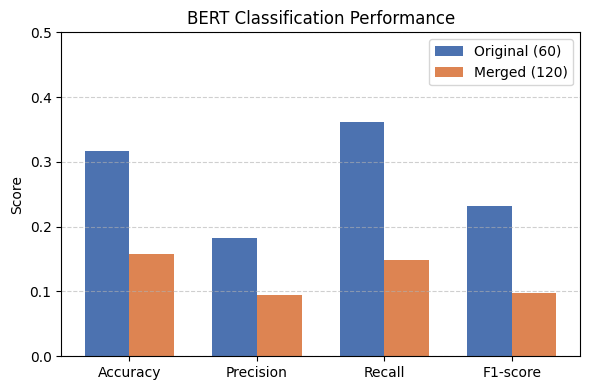

In [46]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
original = [0.317, 0.183, 0.361, 0.232]
merged = [0.158, 0.094, 0.149, 0.097]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, original, width, label='Original (60)', color='#4C72B0')
plt.bar(x + width/2, merged, width, label='Merged (120)', color='#DD8452')

plt.ylabel('Score')
plt.ylim(0, 0.5)
plt.title('BERT Classification Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **Evaluating Whisper–BERT Pipeline on a Large-Scale Medical Dataset**
On the manually recorded surgical-command dataset of size 120, I evaluated the Whisper - BERT pipeline, and based on this, I applied the same approach to the larger dataset - the Medical Speech, Transcription, Intent dataset available in the Kaggle platform.

This aim should help analyze the behavior of the system in the presence of general linguistic-and-acoustic conditions, as well as the model's performance difference in a small domain-corpus versus the large domain-related corpus.

The large dataset includes 6,661 audio examples, spanning over 20 categories of medical intent (for example, “Head ache,” “Joint pain,” “Infected wound”). These audio examples were transcribed using the Whisper tool, followed by classification using the fine-tuned BERT model. The comparison between the accuracy of Whisper’s WER and BERT’s classification accuracy in the datasets helps to understand the scalability of the entire process of speech understanding.

### **step7: Load and Preprocess the Kaggle Dataset**

In [ ]:
!pip install kaggle
import os, shutil, pathlib, subprocess, sys
from google.colab import files

BASE_ROOT = "/content/kaggle_med"
ZIP_PATH  = f"{BASE_ROOT}/medical-speech-transcription-and-intent.zip"
TARGET_DIR = f"{BASE_ROOT}/medspeech"
SRC_DIR_WITH_SPACES = f'{BASE_ROOT}/Medical Speech, Transcription, and Intent'



In [ ]:
from google.colab import files, pathlib
import os, json

uploaded = files.upload()  # select the NEW kaggle.json
fname = next(iter(uploaded))
pathlib.Path("/root/.kaggle").mkdir(parents=True, exist_ok=True)
with open("/root/.kaggle/kaggle.json","wb") as f: f.write(uploaded[fname])
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("Kaggle token updated")


Saving kaggle.json to kaggle.json
Kaggle token updated


In [ ]:


!mkdir -p /content/kaggle_med
!kaggle datasets download -d paultimothymooney/medical-speech-transcription-and-intent -p /content/kaggle_med
!unzip -q -o /content/kaggle_med/medical-speech-transcription-and-intent.zip -d /content/kaggle_med
!mv -f "/content/kaggle_med/Medical Speech, Transcription, and Intent" /content/kaggle_med/medspeech
!ls -lah /content/kaggle_med/medspeech



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent
License(s): other
 99% 5.22G/5.27G [00:13<00:00, 264MB/s]
100% 5.27G/5.27G [00:13<00:00, 427MB/s]
total 1.7M
drwxr-xr-x 3 root root 4.0K Nov 16 18:31 .
drwxr-xr-x 4 root root 4.0K Nov 16 18:32 ..
-rw-r--r-- 1 root root 1.7M Oct 19  2019 overview-of-recordings.csv
drwxr-xr-x 5 root root 4.0K Nov 16 18:31 recordings


### **Step9: Data Preparation and Path Resolution for the Kaggle Dataset**

In [ ]:
#DataFrame with text+intent+audio_path ---
import pandas as pd, glob, os

BASE = "/content/kaggle_med/medspeech"
CSV  = f"{BASE}/overview-of-recordings.csv"
assert os.path.exists(CSV), "overview-of-recordings.csv not found."

df = pd.read_csv(CSV)

In [ ]:
# columns in this dataset
text_col   = "phrase"   # transcript / ground truth text
intent_col = "prompt"   # intent label
file_col   = "file_name"

def resolve_path(file_name: str):
    file_name = str(file_name).strip()
    for pattern in (
        f"{BASE}/recordings/*/{file_name}",
        f"{BASE}/recordings/{file_name}",
    ):
        hits = glob.glob(pattern)
        if hits:
            return hits[0]
    return None

df["audio_path"] = df[file_col].apply(resolve_path)
df = df[~df["audio_path"].isna()].copy().reset_index(drop=True)

In [ ]:
# clean text/labels
df[text_col]   = df[text_col].astype(str).str.strip()
df[intent_col] = df[intent_col].astype(str).str.strip()

print(f" Final dataset size: {len(df)} rows with audio")
print("\nSample rows:")
print(df[[text_col, intent_col, "audio_path"]].head(3))

print("\nIntent distribution (top 15):")
print(df[intent_col].value_counts().head(15))

 Final dataset size: 6661 rows with audio

Sample rows:
                                              phrase            prompt  \
0                    When I remember her I feel down    Emotional pain   
1  When I carry heavy things I feel like breaking...  Hair falling out   
2          there is too much pain when i move my arm       Heart hurts   

                                          audio_path  
0  /content/kaggle_med/medspeech/recordings/test/...  
1  /content/kaggle_med/medspeech/recordings/test/...  
2  /content/kaggle_med/medspeech/recordings/test/...  

Intent distribution (top 15):
prompt
Acne                328
Shoulder pain       320
Joint pain          318
Infected wound      306
Knee pain           305
Cough               293
Feeling dizzy       283
Muscle pain         282
Heart hurts         273
Ear ache            270
Hair falling out    264
Feeling cold        263
Head ache           263
Skin issue          262
Stomach ache        261
Name: count, dtype: int64


In [ ]:
!ls -lah /content/kaggle_med/medspeech
!ls -lah /content/kaggle_med/medspeech/recordings | head -n 5
!ls -lah /content/kaggle_med/medspeech/recordings/test | head -n 5


total 1.7M
drwxr-xr-x 3 root root 4.0K Nov 16 17:21 .
drwxr-xr-x 4 root root 4.0K Nov 16 17:25 ..
-rw-r--r-- 1 root root 1.7M Oct 19  2019 overview-of-recordings.csv
drwxr-xr-x 5 root root 4.0K Nov 16 17:23 recordings
total 372K
drwxr-xr-x 5 root root 4.0K Nov 16 17:23 .
drwxr-xr-x 3 root root 4.0K Nov 16 17:21 ..
drwxr-xr-x 2 root root 312K Nov 16 17:23 test
drwxr-xr-x 2 root root  24K Nov 16 17:23 train
total 5.0G
drwxr-xr-x 2 root root  312K Nov 16 17:23 .
drwxr-xr-x 5 root root  4.0K Nov 16 17:23 ..
-rw-r--r-- 1 root root  513K Oct 19  2019 1249120_13842059_104469105.wav
-rw-r--r-- 1 root root  721K Oct 19  2019 1249120_13842059_105045085.wav


In [ ]:
import pandas as pd
import os

BASE = "/content/kaggle_med/medspeech"
csv_path = f"{BASE}/overview-of-recordings.csv"
df = pd.read_csv(csv_path)

# Print all columns to see what's available
print("Columns in the CSV file:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Columns in the CSV file:
['audio_clipping', 'audio_clipping:confidence', 'background_noise_audible', 'background_noise_audible:confidence', 'overall_quality_of_the_audio', 'quiet_speaker', 'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name', 'phrase', 'prompt', 'writer_id']

First few rows:
   audio_clipping  audio_clipping:confidence background_noise_audible  \
0     no_clipping                     1.0000              light_noise   
1  light_clipping                     0.6803                 no_noise   
2     no_clipping                     1.0000                 no_noise   
3     no_clipping                     1.0000              light_noise   
4     no_clipping                     1.0000                 no_noise   

   background_noise_audible:confidence  overall_quality_of_the_audio  \
0                               1.0000                          3.33   
1                               0.6803                          3.33   
2                               0.

### **Step10: Whisper Transcription on the Full Kaggle Dataset**

In [ ]:
#Transcribe ALL audio with Faster-Whisper
!pip -q install faster-whisper jiwer
!apt -y install -qq ffmpeg

import os, json
import pandas as pd
import torch
from pathlib import Path
from faster_whisper import WhisperModel
from tqdm.auto import tqdm

ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
#Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
compute = "float16" if device == "cuda" else "int8"
gpu_name = torch.cuda.get_device_name(0) if device == "cuda" else "CPU"
print(f"Using device={device} ({gpu_name}), compute_type={compute}")

model = WhisperModel("base", device=device, compute_type=compute)

Using device=cuda (NVIDIA A100-SXM4-40GB), compute_type=float16


In [ ]:
# Expect df from Step 9 with columns: phrase, prompt, audio_path
if 'df' not in globals():
    pass

assert {"phrase", "prompt", "audio_path"}.issubset(df.columns), \
    "Step 9 must create df with phrase, prompt, audio_path."

In [ ]:
#Caching + resumable CSV

CACHE_DIR = Path("/content/whisper_cache_fw"); CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = Path("/content/kaggle_full_whisper_fw.csv")

csv_done = set()
if OUT_CSV.exists():
    try:
        prev = pd.read_csv(OUT_CSV, usecols=["audio_path"])
        csv_done = set(prev["audio_path"])
        print(f"Resuming… {len(csv_done)} rows already written in CSV.")
    except Exception:
        pass

def transcribe_cached(wav_path: str) -> str:
    """Return cached transcription or run model and cache it."""
    cf = CACHE_DIR / (os.path.basename(wav_path) + ".json")
    if cf.exists():
        return json.loads(cf.read_text())["text"]
    # Faster settings: no timestamps, greedy beam_size=1
    segs, _ = model.transcribe(
        wav_path,
        language="en",
        vad_filter=True,
        vad_parameters=dict(min_silence_duration_ms=500),
        without_timestamps=True,
        beam_size=1
    )
    hyp = "".join(s.text for s in segs).strip()
    cf.write_text(json.dumps({"text": hyp}))
    return hyp


Resuming… 4500 rows already written in CSV.


In [ ]:
# Iterate and write each row immediately (best resilience)
import csv

def append_row(path, phrase, prompt, hyp):
    header_needed = not OUT_CSV.exists()
    with OUT_CSV.open("a", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        if header_needed:
            w.writerow(["phrase", "prompt", "audio_path", "hyp"])
        w.writerow([phrase, prompt, path, hyp])

# Skip any file already present in CSV
to_run = df[~df["audio_path"].isin(csv_done)].reset_index(drop=True)

errors = []
print(f"Starting with {len(to_run)} remaining files…")
for i, row in tqdm(to_run.iterrows(), total=len(to_run)):
    ap = row["audio_path"]
    try:
        hyp = transcribe_cached(ap)
        append_row(ap, row["phrase"], row["prompt"], hyp)
    except KeyboardInterrupt:
        print("\n⏸️ Interrupted by user — progress saved so far.")
        break
    except Exception as e:
        errors.append((ap, str(e)))

print(f" Current CSV rows: {len(pd.read_csv(OUT_CSV)) if OUT_CSV.exists() else 0}")
print(f" Errors this run: {len(errors)}")
if errors:
    print("Example errors:", errors[:3])


Starting with 2161 remaining files…


  0%|          | 0/2161 [00:00<?, ?it/s]

 Current CSV rows: 6661
 Errors this run: 0


In [ ]:
#to check the csv file
import pandas as pd

csv_path = "/content/kaggle_full_whisper_fw.csv"
df_full = pd.read_csv(csv_path)
print(f"Total rows: {len(df_full)}")
df_full.head(10)  # show first 10 rows


Total rows: 6661


,phrase,prompt,audio_path,hyp
0,When I remember her I feel down,Emotional pain,/content/kaggle_med/medspeech/recordings/test/...,when I remember her I feel
1,When I carry heavy things I feel like breaking...,Hair falling out,/content/kaggle_med/medspeech/recordings/test/...,When I carry everything so I feel like breakin...
2,there is too much pain when i move my arm,Heart hurts,/content/kaggle_med/medspeech/recordings/test/...,There is so much pain when I move my arm.
3,My son had his lip pierced and it is swollen a...,Infected wound,/content/kaggle_med/medspeech/recordings/test/...,"My time has flipped here, and it is flowing in..."
4,My muscles in my lower back are aching,Infected wound,/content/kaggle_med/medspeech/recordings/test/...,My muscles in my lower back are aches.
5,i have muscle pain that my back\nI Have Muscle...,Foot ache,/content/kaggle_med/medspeech/recordings/test/...,I have the muscle pain that my left leg.
6,I have muscle pain in my left leg,Shoulder pain,/content/kaggle_med/medspeech/recordings/test/...,I have muscle pain at my left leg.
7,I have cut my finger because of playing footba...,Injury from sports,/content/kaggle_med/medspeech/recordings/test/...,I have cut my finger because of playing footba...
8,I have acne in my face and other problems in m...,Skin issue,/content/kaggle_med/medspeech/recordings/test/...,I have acne in my face and other problems in m...
9,I have a strange rash on my arm,Foot ache,/content/kaggle_med/medspeech/recordings/test/...,I have this strange rash on my arm.


In [ ]:
#Check the quality columns
import pandas as pd

BASE = "/content/kaggle_med/medspeech"
meta = pd.read_csv(f"{BASE}/overview-of-recordings.csv")

cols = [
    'background_noise_audible', 'overall_quality_of_the_audio',
    'audio_clipping', 'quiet_speaker'
]
print(meta[cols].head())

# Frequency counts
print("\nBackground noise levels:")
print(meta['background_noise_audible'].value_counts())

print("\nOverall quality rating (1–5 scale):")
print(meta['overall_quality_of_the_audio'].describe())


  background_noise_audible  overall_quality_of_the_audio  audio_clipping  \
0              light_noise                          3.33     no_clipping   
1                 no_noise                          3.33  light_clipping   
2                 no_noise                          3.33     no_clipping   
3              light_noise                          3.33     no_clipping   
4                 no_noise                          4.67     no_clipping   

     quiet_speaker  
0  audible_speaker  
1  audible_speaker  
2  audible_speaker  
3  audible_speaker  
4  audible_speaker  

Background noise levels:
background_noise_audible
no_noise       3523
light_noise    3138
Name: count, dtype: int64

Overall quality rating (1–5 scale):
count    6661.000000
mean        3.678268
std         0.378536
min         3.000000
25%         3.330000
50%         3.670000
75%         4.000000
max         5.000000
Name: overall_quality_of_the_audio, dtype: float64


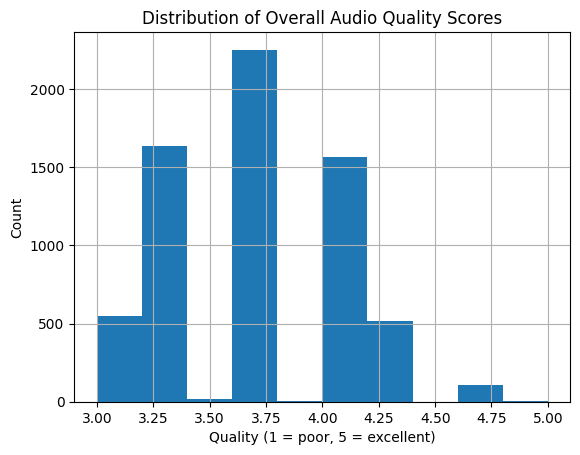

In [ ]:
#Visualize audio quality distribution
import matplotlib.pyplot as plt

meta['overall_quality_of_the_audio'].hist(bins=10)
plt.title("Distribution of Overall Audio Quality Scores")
plt.xlabel("Quality (1 = poor, 5 = excellent)")
plt.ylabel("Count")
plt.show()


In [ ]:
# --- Audio Quality Summary ---
import pandas as pd

BASE = "/content/kaggle_med/medspeech"
meta = pd.read_csv(f"{BASE}/overview-of-recordings.csv")

# Compute percentages
noise_counts = meta["background_noise_audible"].value_counts()
noise_percent = (noise_counts / noise_counts.sum() * 100).round(1)

clipping_counts = meta["audio_clipping"].value_counts()
speaker_counts = meta["quiet_speaker"].value_counts()

mean_quality = meta["overall_quality_of_the_audio"].mean()
std_quality = meta["overall_quality_of_the_audio"].std()
min_quality = meta["overall_quality_of_the_audio"].min()
max_quality = meta["overall_quality_of_the_audio"].max()

print("🎧 AUDIO QUALITY SUMMARY\n" + "-"*35)
print(f"Total recordings: {len(meta)}")
print(f"Average quality score: {mean_quality:.2f} ± {std_quality:.2f} (min={min_quality}, max={max_quality})\n")

print("Background noise levels:")
for level, pct in noise_percent.items():
    print(f"  • {level:<15}: {pct:>5.1f}%")

print("\nAudio clipping:")
for level, count in clipping_counts.items():
    print(f"  • {level:<15}: {count:>5} recordings")

print("\nSpeaker loudness:")
for level, count in speaker_counts.items():
    print(f"  • {level:<15}: {count:>5} recordings")

# interpretive note
if mean_quality > 3.5 and (noise_percent.get("no_noise", 0) + noise_percent.get("light_noise", 0)) > 90:
    print("\n Interpretation: Dataset consists mostly of clear or lightly noisy speech with consistent loudness.")
else:
    print("\n Interpretation: Dataset includes a wider range of acoustic conditions that may affect ASR robustness.")

🎧 AUDIO QUALITY SUMMARY
-----------------------------------
Total recordings: 6661
Average quality score: 3.68 ± 0.38 (min=3.0, max=5.0)

Background noise levels:
  • no_noise       :  52.9%
  • light_noise    :  47.1%

Audio clipping:
  • no_clipping    :  6607 recordings
  • light_clipping :    54 recordings

Speaker loudness:
  • audible_speaker:  6646 recordings
  • quiet_speaker  :    15 recordings

✅ Interpretation: Dataset consists mostly of clear or lightly noisy speech with consistent loudness.


### **Step 11: Whisper Evaluation on the Large Medical Dataset**

In [ ]:
#Evaluate Whisper performance (WER & ESA)
from jiwer import wer
import pandas as pd


In [ ]:
# Load the full transcription CSV created in Step 10
csv_path = "/content/kaggle_full_whisper_fw.csv"
full = pd.read_csv(csv_path)

In [ ]:
# quick sanity check
print("Rows in dataset:", len(full))
print(full.columns)

Rows in dataset: 6661
Index(['phrase', 'prompt', 'audio_path', 'hyp'], dtype='object')


In [ ]:
# Define helper for ESA
def exact_sentence_accuracy(refs, hyps):
    """Compute the ratio of sentences that are an exact match."""
    matches = sum(r.strip().lower() == h.strip().lower() for r, h in zip(refs, hyps))
    return matches / len(refs)

In [ ]:

#  Coerce to string, replace NaN with empty, strip spaces
for col in ["phrase", "hyp"]:
    full[col] = full[col].astype(str).fillna("").str.strip()

# drop rows where either side is empty (safer for metrics)
before = len(full)
full_clean = full[(full["phrase"] != "") & (full["hyp"] != "")]
dropped = before - len(full_clean)
print(f"Dropped {dropped} rows with empty phrase/hyp (kept {len(full_clean)})")

# 3) Exact sentence accuracy (case-insensitive)
def exact_sentence_accuracy(refs, hyps):
    return sum(r.lower()==h.lower() for r,h in zip(refs,hyps)) / len(refs)

# 4) Compute metrics
wer_full = wer(full_clean["phrase"].tolist(), full_clean["hyp"].tolist())
esa_full = exact_sentence_accuracy(full_clean["phrase"].tolist(), full_clean["hyp"].tolist())

print("\n Whisper Evaluation on Full Kaggle Dataset")
print("-"*50)
print(f"Word Error Rate (WER): {wer_full:.3f}  →  {(1-wer_full)*100:.1f}% word-level accuracy")
print(f"Exact Sentence Accuracy (ESA): {esa_full*100:.1f}%")
print("-"*50)


Dropped 0 rows with empty phrase/hyp (kept 6661)

 Whisper Evaluation on Full Kaggle Dataset
--------------------------------------------------
Word Error Rate (WER): 0.234  →  76.6% word-level accuracy
Exact Sentence Accuracy (ESA): 15.2%
--------------------------------------------------


### **Step12: BERT Intent Classification on Reference text (phrase → prompt)**

In [ ]:
# Install libs (fast + GPU-friendly)
!pip -q install transformers datasets accelerate scikit-learn

import pandas as pd, numpy as np, torch, random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
# Reproducibility
CSV_PATH = "/content/kaggle_full_whisper_fw.csv"
TEXT_COL = "phrase"   # reference (ground-truth) transcript
LABEL_COL = "prompt"
MODEL_NAME = "distilbert-base-uncased"
SEED = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)


In [ ]:
# Load data
full = pd.read_csv(CSV_PATH)

# Basic cleaning (defensive)
for c in [TEXT_COL, LABEL_COL]:
    full[c] = full[c].astype(str).str.strip()

# Encode labels
le = LabelEncoder()
full["label_id"] = le.fit_transform(full[LABEL_COL])
num_labels = len(le.classes_)
print("Num labels:", num_labels)

Num labels: 25


In [ ]:
# Use reference text ("phrase") and labels ("prompt")
text_col = "phrase"
label_col = "prompt"

In [ ]:
# Encode labels
le = LabelEncoder()
full["label_id"] = le.fit_transform(full[label_col])
num_labels = len(le.classes_)
print("Num labels:", num_labels)

Num labels: 25


In [ ]:
# Train/val/test split (stratified)
train_df, temp_df = train_test_split(
    full, test_size=0.2, random_state=SEED, stratify=full["label_id"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label_id"]
)

In [ ]:
# HF datasets
train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label_id"]], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, "label_id"]],   preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label_id"]],  preserve_index=False)

In [ ]:
#Tokenizer & Mapping
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok_fn(batch):
    return tok(batch[TEXT_COL], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(tok_fn, batched=True)
val_tok   = val_ds.map(tok_fn, batched=True)
test_tok  = test_ds.map(tok_fn, batched=True)




Map:   0%|          | 0/5328 [00:00<?, ? examples/s]

Map:   0%|          | 0/666 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

In [ ]:

# Prep for Trainer (columns)
def prep_for_torch(ds):
    # Keep only tokens + label_id (rename to labels)
    keep = ["input_ids", "attention_mask", "label_id"]
    drop_cols = [c for c in ds.column_names if c not in keep]
    if drop_cols:
        ds = ds.remove_columns(drop_cols)
    if "label_id" in ds.column_names and "labels" not in ds.column_names:
        ds = ds.rename_column("label_id", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

train_tok = prep_for_torch(train_tok)
val_tok   = prep_for_torch(val_tok)
test_tok  = prep_for_torch(test_tok)

In [ ]:
!pip -q install -U "transformers>=4.41" "datasets>=2.18" "accelerate>=0.27"
import transformers, datasets, accelerate
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Accelerate:", accelerate.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 51.9 MB/s eta 0:00:00
Transformers: 4.57.1
Datasets: 4.0.0
Accelerate: 1.11.0


In [ ]:
# Model & Trainer
from inspect import signature
from transformers import TrainingArguments

def arg_supported(name):
    return name in signature(TrainingArguments.__init__).parameters

extra = {}

if arg_supported("eval_strategy"):
    extra["eval_strategy"] = "epoch"
elif arg_supported("evaluation_strategy"):
    extra["evaluation_strategy"] = "epoch"

if arg_supported("save_strategy"):
    extra["save_strategy"] = "epoch"

if arg_supported("load_best_model_at_end"):
    extra["load_best_model_at_end"] = True

if arg_supported("metric_for_best_model"):
    extra["metric_for_best_model"] = "accuracy"

if arg_supported("optim"):
    extra["optim"] = "adamw_torch"

args = TrainingArguments(
    output_dir="/content/bert_ref_intent",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
    **extra
)


model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

trainer.train()
ref_metrics = trainer.evaluate(test_tok)
print(" BERT on REFERENCE text (phrase):", ref_metrics)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1333216759.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.086400,0.561102,0.953453,0.952889,0.956915,0.953453
2,0.223600,0.116229,0.984985,0.984289,0.986834,0.984985
3,0.081700,0.072615,0.989489,0.989402,0.990888,0.989489


 BERT on REFERENCE text (phrase): {'eval_loss': 0.060294270515441895, 'eval_accuracy': 0.9955022488755623, 'eval_f1': 0.9954992886731984, 'eval_precision': 0.9956601560330947, 'eval_recall': 0.9955022488755623, 'eval_runtime': 0.2601, 'eval_samples_per_second': 2564.759, 'eval_steps_per_second': 80.75, 'epoch': 3.0}


### **Step 13: BERT on Whisper text (hyp → prompt)**

In [ ]:
#Config
CSV_PATH  = "/content/kaggle_full_whisper_fw.csv"
TEXT_COL  = "hyp"       # use Whisper outputs here
LABEL_COL = "prompt"
MODEL_NAME = "distilbert-base-uncased"
SEED = 42

import pandas as pd, numpy as np, torch, random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)



In [ ]:
# Load & clean
full = pd.read_csv(CSV_PATH)
for c in [TEXT_COL, LABEL_COL]:
    full[c] = full[c].astype(str).str.strip()

In [ ]:
# Encode labels (same dataset ⇒ same classes)
le = LabelEncoder()
full["label_id"] = le.fit_transform(full[LABEL_COL])
num_labels = len(le.classes_)
print("Num labels:", num_labels)

Num labels: 25


In [ ]:
# Stratified split 80/10/10
train_df, temp_df = train_test_split(full, test_size=0.2, random_state=SEED, stratify=full["label_id"])
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label_id"])

train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label_id"]], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, "label_id"]],   preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label_id"]],  preserve_index=False)

In [ ]:
#Tokenizer & mapping
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
def tok_fn(batch):
    return tok(batch[TEXT_COL], truncation=True, padding="max_length", max_length=128)

train_tok = train_ds.map(tok_fn, batched=True)
val_tok   = val_ds.map(tok_fn, batched=True)
test_tok  = test_ds.map(tok_fn, batched=True)

Map:   0%|          | 0/5328 [00:00<?, ? examples/s]

Map:   0%|          | 0/666 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

In [ ]:
# Prep for Trainer
def prep_for_torch(ds):
    keep = ["input_ids", "attention_mask", "label_id"]
    drop = [c for c in ds.column_names if c not in keep]
    if drop: ds = ds.remove_columns(drop)
    if "label_id" in ds.column_names and "labels" not in ds.column_names:
        ds = ds.rename_column("label_id", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

train_tok = prep_for_torch(train_tok)
val_tok   = prep_for_torch(val_tok)
test_tok  = prep_for_torch(test_tok)

In [ ]:
# --- Model & Trainer (version-safe TrainingArguments) ---
from inspect import signature
from transformers import TrainingArguments

def arg_supported(name):
    return name in signature(TrainingArguments.__init__).parameters

extra = {}
if arg_supported("evaluation_strategy"):
    extra["evaluation_strategy"] = "epoch"
elif arg_supported("eval_strategy"):
    extra["eval_strategy"] = "epoch"
if arg_supported("save_strategy"):
    extra["save_strategy"] = "epoch"
if arg_supported("load_best_model_at_end"):
    extra["load_best_model_at_end"] = True
if arg_supported("metric_for_best_model"):
    extra["metric_for_best_model"] = "accuracy"
if arg_supported("optim"):
    extra["optim"] = "adamw_torch"

args = TrainingArguments(
    output_dir="/content/bert_hyp_intent",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
    **extra
)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

trainer.train()
hyp_metrics = trainer.evaluate(test_tok)
print("BERT on WHISPER text (hyp):", hyp_metrics)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1275236545.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,1.659100,1.211947,0.779279,0.765233,0.787660,0.773894
2,0.850100,0.737570,0.842342,0.840647,0.846255,0.842690
3,0.583500,0.642534,0.863363,0.862377,0.866511,0.863361


BERT on WHISPER text (hyp): {'eval_loss': 0.6383920311927795, 'eval_accuracy': 0.8605697151424287, 'eval_f1_macro': 0.8607260787445515, 'eval_precision_macro': 0.8644769391419751, 'eval_recall_macro': 0.862774188042312, 'eval_runtime': 0.286, 'eval_samples_per_second': 2332.168, 'eval_steps_per_second': 73.427, 'epoch': 3.0}


In [ ]:
#Quick comparison cell
whisper_wer = 0.234
whisper_esa = 0.152

def pick(d, *candidates):
    for k in candidates:
        if k in d:
            return d[k]
    return float("nan")  # or 0.0

ref_acc = pick(ref_metrics, "eval_accuracy")
ref_f1  = pick(ref_metrics, "eval_f1_macro", "eval_f1")

hyp_acc = pick(hyp_metrics, "eval_accuracy")
hyp_f1  = pick(hyp_metrics, "eval_f1_macro", "eval_f1")

print("\n=== Final Comparison (Kaggle) ===")
print(f"Whisper →  WER: {whisper_wer:.3f}  |  ESA: {whisper_esa*100:.1f}%")
print(f"BERT (reference) → Acc: {ref_acc:.3f}, F1: {ref_f1:.3f}")
print(f"BERT (whisper)   → Acc: {hyp_acc:.3f}, F1: {hyp_f1:.3f}")
print("Δ accuracy due to ASR noise:", f"{(ref_acc - hyp_acc):.3f}")


=== Final Comparison (Kaggle) ===
Whisper →  WER: 0.234  |  ESA: 15.2%
BERT (reference) → Acc: 0.996, F1: 0.995
BERT (whisper)   → Acc: 0.861, F1: 0.861
Δ accuracy due to ASR noise: 0.135


In [ ]:
# Compact results table
import pandas as pd
summary = pd.DataFrame([
    ["Whisper (ASR)", "WER", 0.234],
    ["Whisper (ASR)", "ESA", 0.152],
    ["BERT (phrase→prompt)", "Accuracy", 0.996],
    ["BERT (phrase→prompt)", "F1", 0.995],
    ["BERT (hyp→prompt)", "Accuracy", 0.861],
    ["BERT (hyp→prompt)", "F1", 0.861],
], columns=["Stage","Metric","Value"])
summary


,Stage,Metric,Value
0,Whisper (ASR),WER,0.234
1,Whisper (ASR),ESA,0.152
2,BERT (phrase→prompt),Accuracy,0.996
3,BERT (phrase→prompt),F1,0.995
4,BERT (hyp→prompt),Accuracy,0.861
5,BERT (hyp→prompt),F1,0.861


In [ ]:
# Reference predictions using your existing model
ref_pred_logits = trainer.predict(test_tok).predictions
ref_pred = ref_pred_logits.argmax(axis=-1)
ref_true = np.asarray(test_tok["labels"])

# Label names from your existing model
label_names = [model.config.id2label[i] for i in range(model.config.num_labels)]

def per_class_acc(y_true, y_pred, label_names):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    rows = []
    for i, name in enumerate(label_names):
        idx = (y_true == i)
        n = idx.sum()
        acc = np.nan if n == 0 else float((y_pred[idx] == i).mean())
        rows.append([name, int(n), acc])
    return pd.DataFrame(rows, columns=["Intent","TestCount","Accuracy"])

ref_df = per_class_acc(ref_true, ref_pred, label_names)

# Display results for reference model only
print("📊 Reference Model Performance by Intent:")
display(ref_df.sort_values("Accuracy", ascending=False).head(10))
print("\n📊 Worst Performing Intents (Reference Model):")
display(ref_df.sort_values("Accuracy", ascending=True).head(10))

📊 Reference Model Performance by Intent:


,Intent,TestCount,Accuracy
7,LABEL_7,27,1.000000
15,LABEL_15,23,0.956522
11,LABEL_11,23,0.956522
22,LABEL_22,32,0.937500
14,LABEL_14,31,0.935484
8,LABEL_8,29,0.931034
12,LABEL_12,26,0.923077
9,LABEL_9,22,0.909091
0,LABEL_0,33,0.909091
21,LABEL_21,20,0.900000



📊 Worst Performing Intents (Reference Model):


,Intent,TestCount,Accuracy
17,LABEL_17,32,0.687500
4,LABEL_4,30,0.700000
16,LABEL_16,25,0.720000
5,LABEL_5,27,0.740741
2,LABEL_2,24,0.791667
18,LABEL_18,31,0.806452
19,LABEL_19,28,0.821429
1,LABEL_1,26,0.846154
24,LABEL_24,26,0.846154
13,LABEL_13,28,0.857143


In [ ]:
#Per-utterance sentence accuracy vs. length (diagnostic)
import numpy as np, pandas as pd
full = pd.read_csv("/content/kaggle_full_whisper_fw.csv")
full["sent_ok"] = (full["phrase"].astype(str).str.strip().str.lower()
                   == full["hyp"].astype(str).str.strip().str.lower()).astype(int)
full["len_words"] = full["phrase"].astype(str).str.split().apply(len)
full.groupby(pd.cut(full["len_words"], [0,3,6,10,20,100]))["sent_ok"].mean()
